# MH proposals for discrete Potts models

This notebook performs experiments with MCMC samplers from [Grathwohl et al. (2021)](https://arxiv.org/abs/2102.04509), [Zanella (2017)](https://arxiv.org/abs/1711.07424), and [Zhang et al. (2022)](https://arxiv.org/abs/2206.09914).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math
from collections import Counter
from typing import Callable, Iterator, Optional, Tuple

import numpy as np
import torch
import torch.distributions as dist
import pyro
import matplotlib
import matplotlib.pyplot as plt
from torch.distributions import constraints
from opt_einsum import contract as einsum
from pyro.ops.stats import autocorrelation
from tqdm.auto import tqdm

matplotlib.rcParams.update({'figure.facecolor': "white"})
matplotlib.rcParams.update({'figure.dpi': 200})

Let's compare two of Zanella's balancing functions `g(-)`.

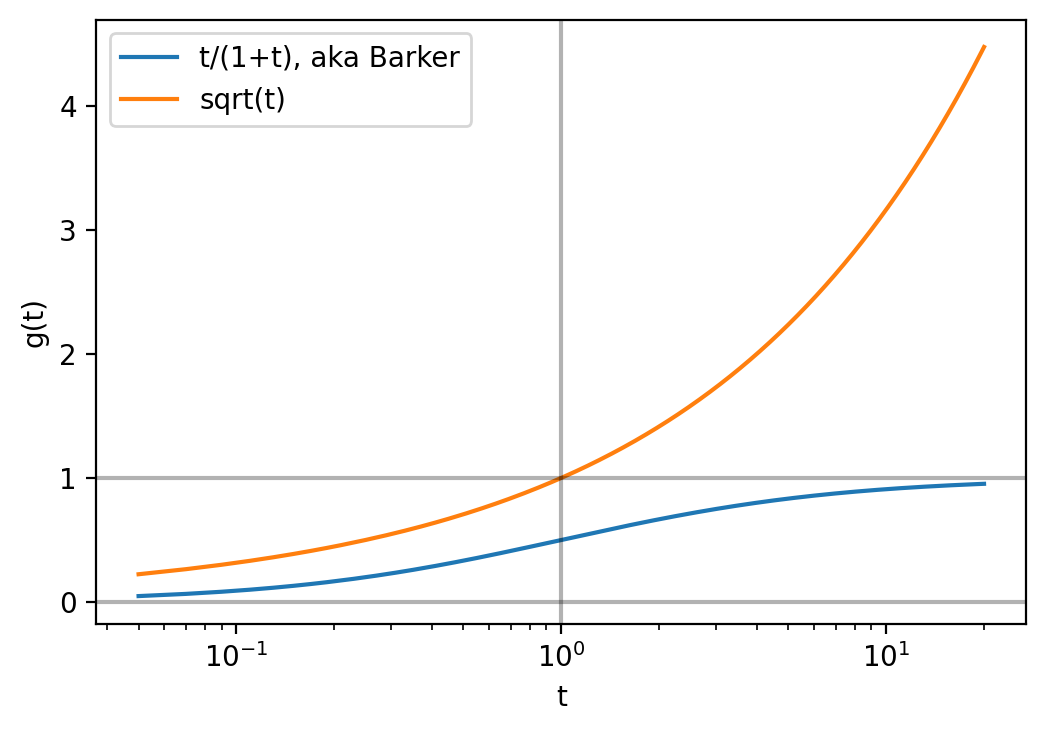

In [3]:
t = np.linspace(0.05,20,1000)
plt.plot(t, t / (1 + t), label="t/(1+t), aka Barker")
plt.plot(t, t ** 0.5, label="sqrt(t)")
plt.xlabel("t")
plt.ylabel("g(t)")
plt.xscale("log")
plt.axvline(1, color="black", alpha=0.3)
plt.axhline(0, color="black", alpha=0.3)
plt.axhline(1, color="black", alpha=0.3)
plt.legend(loc="best");

Next consider a sparse Potts distribution class, where we implement a `.log_prob_nbhd()` method for locally-informed Metropolis-Hastings sampling.

In [4]:
class OneHotCategoricalPotts(dist.Distribution):
    arg_constraints = {
        "vertex_weights": constraints.independent(constraints.real, 2),
        "edge_weights": constraints.independent(constraints.real, 3),
    }
    support = constraints.independent(constraints.one_hot, 1)

    def __init__(
        self, vertex_weights: torch.Tensor, edge_weights: torch.Tensor, edges: torch.Tensor
    ):
        self.vertex_weights = vertex_weights
        self.edge_weights = edge_weights
        self.edges = edges
        assert edges.dim() == 2
        assert edges.shape[0] == 2
        assert all(len(set(edge)) == 2 for edge in edges.T.tolist()), "self edge"
        super().__init__(batch_shape=(), event_shape=vertex_weights.shape)

    def log_prob(self, x_onehot: torch.Tensor) -> torch.Tensor:
        """
        Returns non-normalized lob_prob.
        """
        # Note this differentiable version performs about 400x more work than
        # necessary due to the one-hot encoding. A better-engineered version
        # would hand-implement the .log_prob() and .log_prob_nbhd() methods
        # using index-encoding rather than one-hot-encoding.
        if self._validate_args:
            assert x_onehot.dim() >= 2
            self._validate_sample(x_onehot)
        head, tail = x_onehot[..., self.edges, :]
        return (
            einsum("...vk,vk->...", x_onehot, self.vertex_weights)
            + einsum("...ej,...ek,ejk->...", head, tail, self.edge_weights)
        )

    def log_prob_nbhd(self, x_onehot: torch.Tensor) -> Tuple[float, torch.tensor]:
        """
        Assuming there are no self-edges (as asserted above),
        the gradient approximation of Grathwohl et al. (2021) is exact.
        """
        x_grad = x_onehot.clone().requires_grad_()
        log_prob = self.log_prob(x_grad)
        nbhd = torch.autograd.grad(log_prob, x_grad)[0].detach()
        nbhd -= (nbhd * x_onehot).sum(-1, True)
        assert not nbhd.requires_grad
        return log_prob.detach().item(), nbhd
    
    def enumerate_support(self):
        p, k = self.event_shape
        result = torch.zeros(k ** p, p, k)
        ks = [list(range(k))] * p
        for a, cs in enumerate(itertools.product(*ks)):
            for b, c in enumerate(cs):
                result[a, b, c] = 1
        return result

In [5]:
def random_potts(p: int=100, k: int=20, density: float=0.1, temperature: float=2):
    P = torch.arange(p)
    e = p * (p - 1) // 2
    complete_edges = torch.stack([
        P[:, None].expand(p, p), P.expand(p, p)
    ], 0).reshape(2, p * p)
    complete_edges = complete_edges[:, complete_edges[0] < complete_edges[1]]
    assert complete_edges.shape == (2, e)
    complete_edges = complete_edges[:, torch.randperm(e)]
    edges = complete_edges[:, :round(density * e)].clone()
    vertex_weights = torch.randn(p, k) / temperature
    edge_weights = torch.randn(edges.shape[1], k, k) / temperature
    return OneHotCategoricalPotts(vertex_weights, edge_weights, edges)

In [6]:
def test_enumerate_support(p, k, expected):
    actual = random_potts(p, k).enumerate_support().tolist()
    assert actual == expected
    
test_enumerate_support(
    2, 2,
    [
        [[1, 0], [1, 0]],
        [[1, 0], [0, 1]],
        [[0, 1], [1, 0]],
        [[0, 1], [0, 1]],
    ],
)
    
test_enumerate_support(
    2, 3,
    [
        [[1, 0, 0], [1, 0, 0]],
        [[1, 0, 0], [0, 1, 0]],
        [[1, 0, 0], [0, 0, 1]],
        [[0, 1, 0], [1, 0, 0]],
        [[0, 1, 0], [0, 1, 0]],
        [[0, 1, 0], [0, 0, 1]],
        [[0, 0, 1], [1, 0, 0]],
        [[0, 0, 1], [0, 1, 0]],
        [[0, 0, 1], [0, 0, 1]],
    ],
)

In [7]:
def gibbs_with_gradients(
    d: OneHotCategoricalPotts, g: callable
) -> Iterator[Tuple[torch.Tensor, int]]:
    # Initialize to random uniform.
    p, k = d.event_shape
    x0 = torch.zeros(p, k)
    x0[torch.arange(p), torch.randint(0, k - 1, (p,))] = 1
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = g(nbhd)
    logq0 -= logq0.reshape(-1).logsumexp(0)  # normalize

    while True:
        # Propose.
        ij = dist.Categorical(logits=logq0.reshape(-1)).sample().item()
        i, j1 = divmod(ij, k)
        x1 = x0.clone()
        x1[i] = 0
        x1[i, j1] = 1
        j0 = int(x0[i].max(0).indices)
        if j1 == j0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = g(nbhd)
        logq1 -= logq1.reshape(-1).logsumexp(0)  # normalize
        ratio = (logp1 - logp0 + logq1[i, j0] - logq0[i, j1]).exp()
        accept = int(ratio > torch.rand(()))
        if accept:
            x0, logp0, logq0 = x1, logp1, logq1
        yield x0, accept

In [8]:
def discrete_langevin(
    d: OneHotCategoricalPotts, g: callable, stepsize:float = 1.0
) -> Iterator[Tuple[torch.Tensor, int]]:
    """
    Implements Metropolis-Hastings with discrete Langevin proposals
    from Zhang et al. (2022) https://arxiv.org/abs/2206.09914.
    """
    # Initialize to random uniform.
    p, k = d.event_shape
    x0 = torch.zeros(p, k)
    i = torch.arange(p)
    j = torch.randint(0, k - 1, (p,))
    x0[i, j] = 1
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = g(nbhd)
    logq0 += x0 / stepsize
    logq0 -= logq0.logsumexp(-1, True)  # normalize

    while True:
        # Propose.
        j = dist.Categorical(logits=logq0).sample()
        x1 = torch.zeros_like(x0)
        x1[i, j] = 1
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = g(nbhd)
        logq1 += x1 / stepsize
        logq1 -= logq1.logsumexp(-1, True)  # normalize
        ratio = (logp1 - logp0 + torch.tensordot(logq1, x0) - torch.tensordot(logq0, x1)).exp()
        if ratio > torch.rand(()):
            x0, logp0, logq0 = x1, logp1, logq1
        else:
            distance = 0
        yield x0, distance

In [9]:
def adaptive_langevin(
    d: OneHotCategoricalPotts, g: callable,
) -> Iterator[Tuple[torch.Tensor, int]]:
    def make_logq(x, nbhd):
        logq = g(nbhd)
        # Set step size so that q(x1[i] = x0[i]) > 1/2 for every i.
        logq += x * logq.exp().sum(-1).max().sub(1).clamp(min=1).log()
        logq -= logq.logsumexp(-1, True)  # normalize
        return logq
        
    # Initialize to random uniform.
    p, k = d.event_shape
    x0 = torch.zeros(p, k)
    i = torch.arange(p)
    j = torch.randint(0, k - 1, (p,))
    x0[i, j] = 1
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = make_logq(x0, nbhd)

    while True:
        # Propose.
        j = dist.Categorical(logits=logq0).sample()
        x1 = torch.zeros_like(x0)
        x1[i, j] = 1
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = make_logq(x1, nbhd)
        ratio = (logp1 - logp0 + torch.tensordot(logq1, x0) - torch.tensordot(logq0, x1)).exp()
        if ratio > torch.rand(()):
            x0, logp0, logq0 = x1, logp1, logq1
        else:
            distance = 0
        yield x0, distance

## Testing the sampler

Let's quick test that the sampler draws correct samples.

In [10]:
def one_hot_to_hashable(x_onehot: torch.Tensor) -> Tuple[int]:
    assert x_onehot.dim() == 2
    assert (x_onehot.sum(-1) == 1).all()
    return tuple(x_onehot.max(-1).indices.tolist())

In [11]:
def get_histogram(n, d, g, mcmc):
    hist = Counter()
    distances = Counter()
    for i, (x, distance) in tqdm(enumerate(mcmc(d, g)), total=n):
        hist[one_hot_to_hashable(x)] += 1
        if i >= n:
            break
        distances[distance] += 1
    mean = sum(k * v for k, v in distances.items()) / sum(distances.values())
    print(f"mean distance = {mean:0.3f}")
    return hist

In [12]:
def sample_efficiency(counts: torch.Tensor, probs: torch.Tensor) -> float:
    total = counts.sum()
    chisq = (counts - total * probs).square(s).sum().div(total)
    return float(1 / chisq)

In [13]:
print(sample_efficiency(torch.tensor([99, 101]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([90, 110]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([9900, 10100]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([80, 120]), torch.tensor([0.5, 0.5])))

100.0
1.0
1.0
0.25


In [14]:
def test_gof(mcmc, p, k, n=20000):
    pyro.set_rng_seed(20220709)
    d = random_potts(p, k, density=0.9)
    hist = get_histogram(n, d, g=torch.nn.functional.logsigmoid, mcmc=mcmc)
    xs = d.enumerate_support()
    log_probs = {one_hot_to_hashable(x): float(d.log_prob(x)) for x in xs}  # non-normalized
    log_total = float(torch.tensor(list(log_probs.values())).logsumexp(-1))
    probs_dict = {k: math.exp(v - log_total) for k, v in log_probs.items()}
    keys = sorted(probs_dict)
    probs = torch.tensor([probs_dict[k] for k in keys])
    probs, indices = probs.sort(0, descending=True)
    counts = torch.tensor([hist.pop(k, 0) for k in keys])[indices]
    assert not hist, f"invalid samples: {set(hist)}"
    eff = sample_efficiency(counts, probs)
    plt.figure(figsize=(6, 3))
    plt.plot(probs, "k--", label="truth")
    plt.plot(counts / counts.sum(), label="empirical")
    plt.ylabel("probability")
    plt.xlabel("rank")
    plt.legend(loc="best")
    plt.title(f"efficiency = {eff:0.4g}")

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.354


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.498


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.572


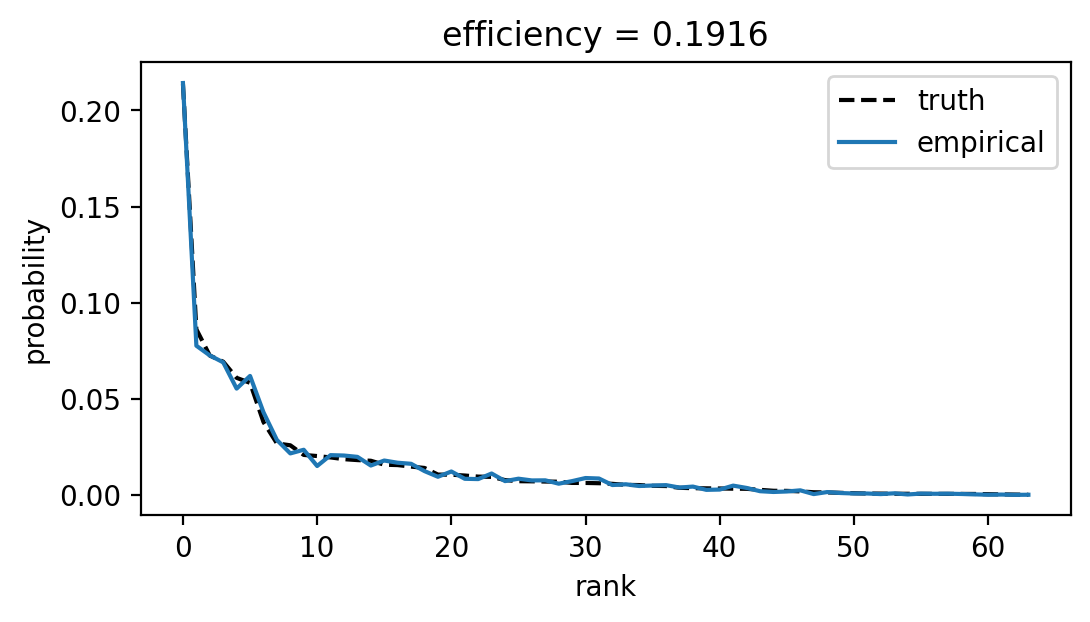

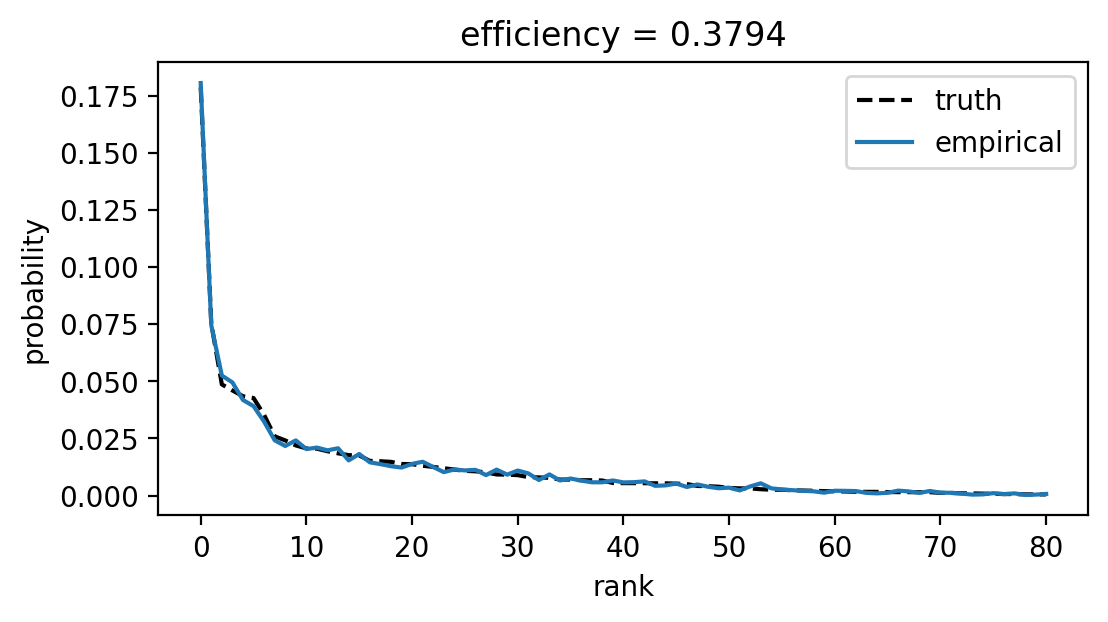

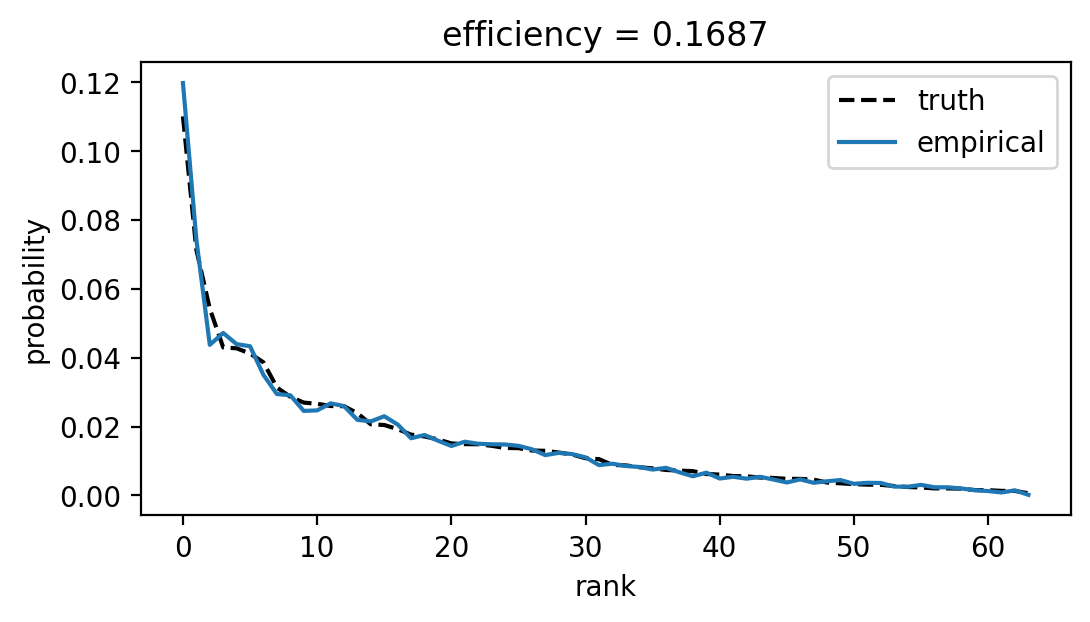

In [15]:
test_gof(gibbs_with_gradients, 6, 2)
test_gof(gibbs_with_gradients, 4, 3)
test_gof(gibbs_with_gradients, 3, 4)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.824


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.924


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.902


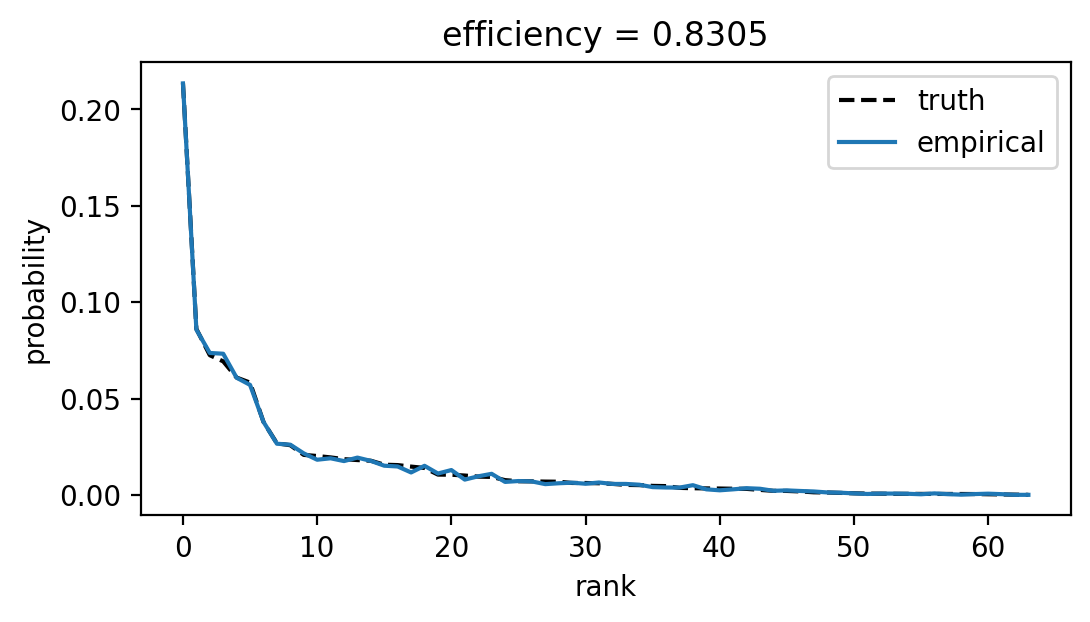

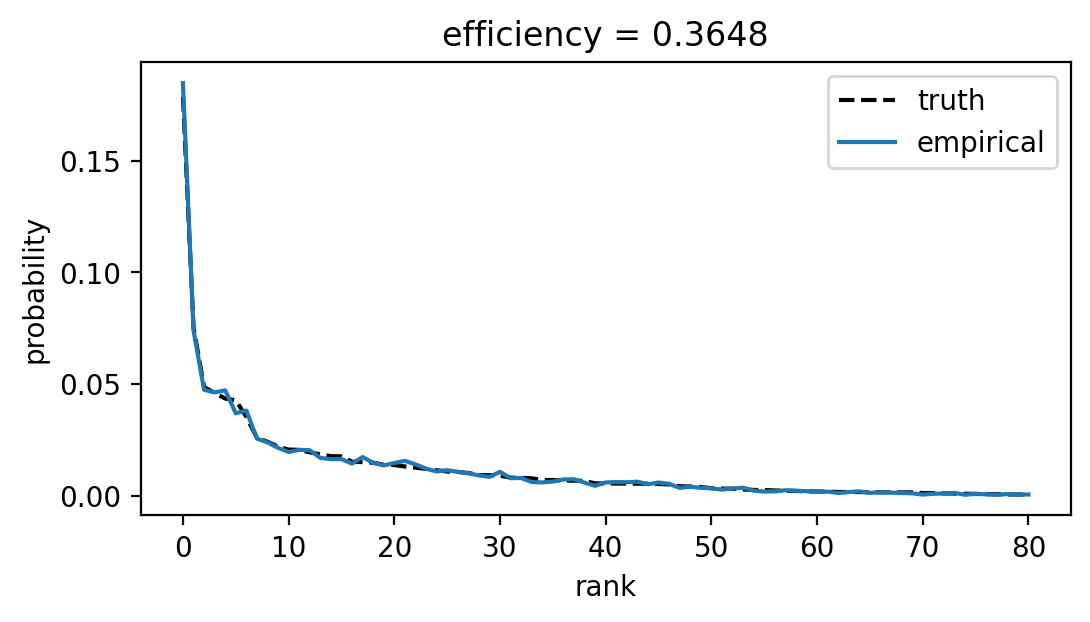

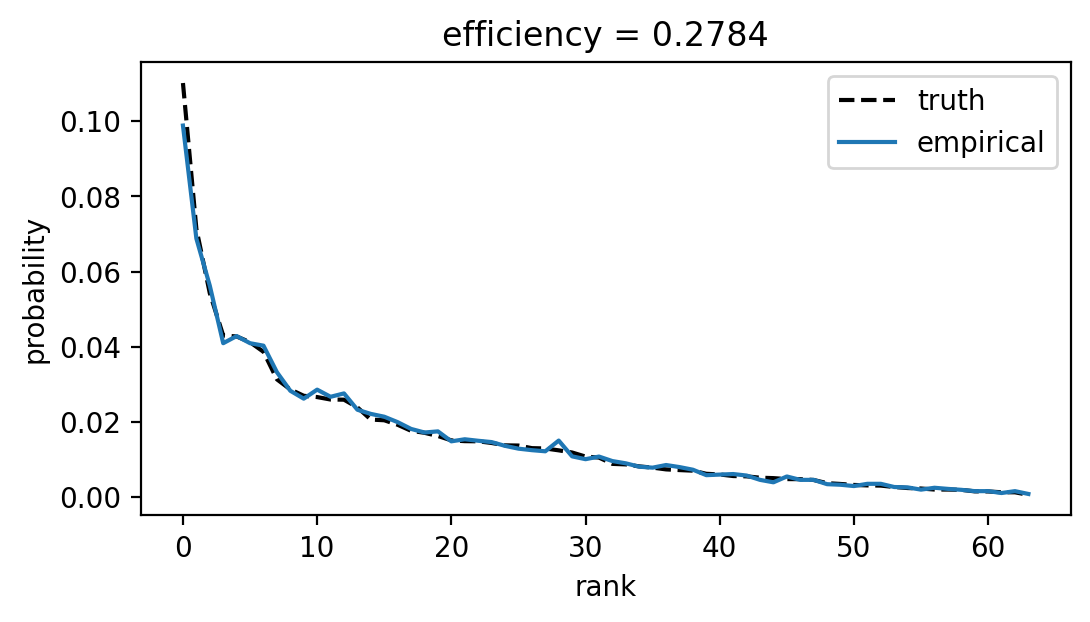

In [16]:
test_gof(discrete_langevin, 6, 2)
test_gof(discrete_langevin, 4, 3)
test_gof(discrete_langevin, 3, 4)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.166


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.215


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.024


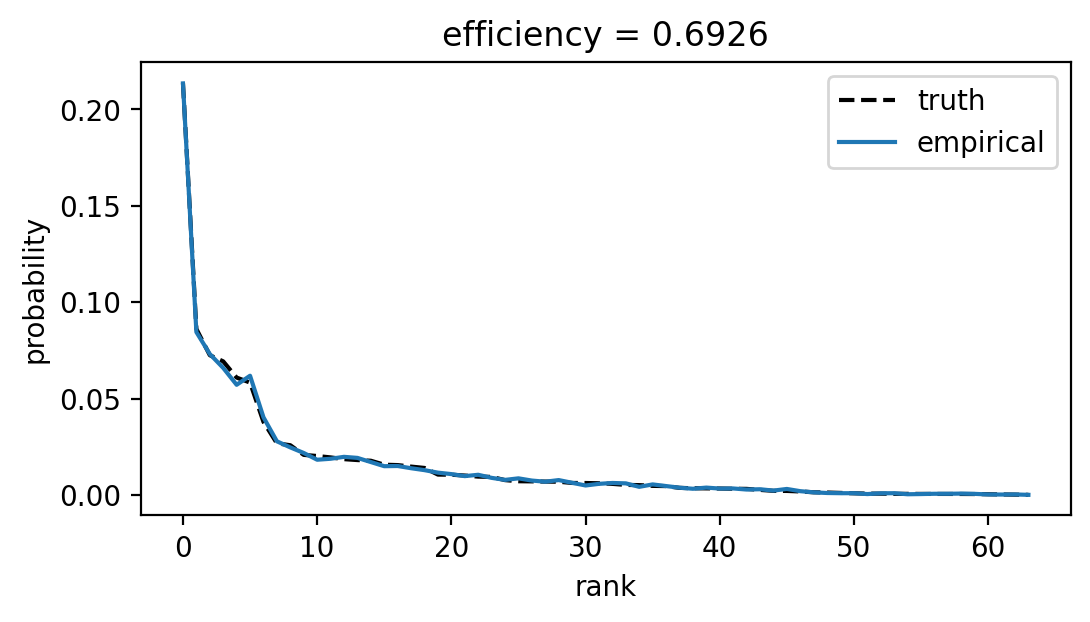

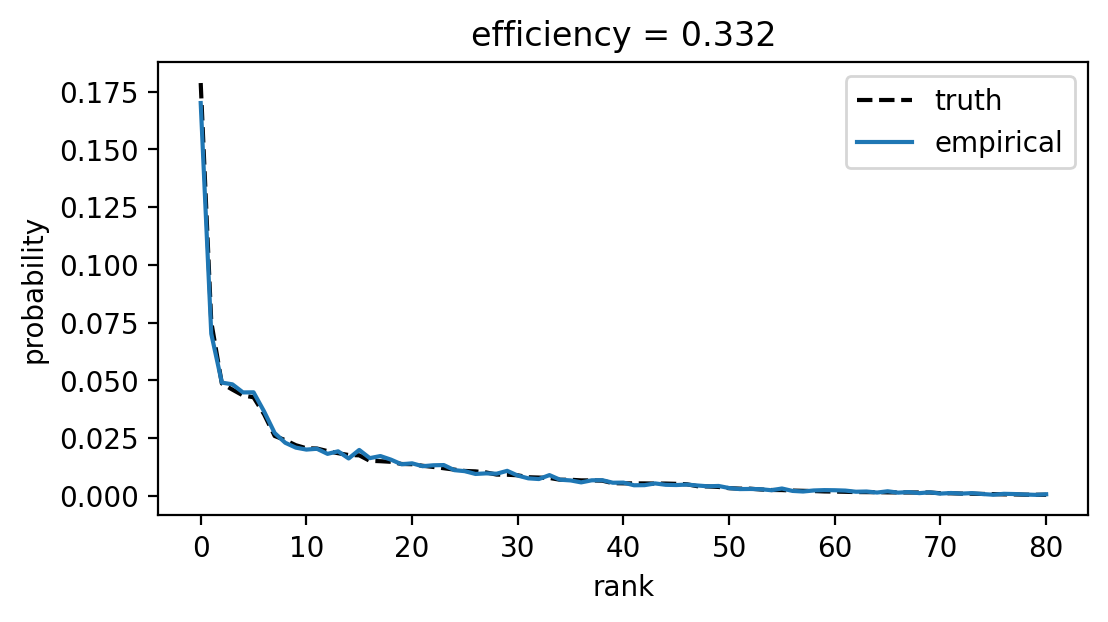

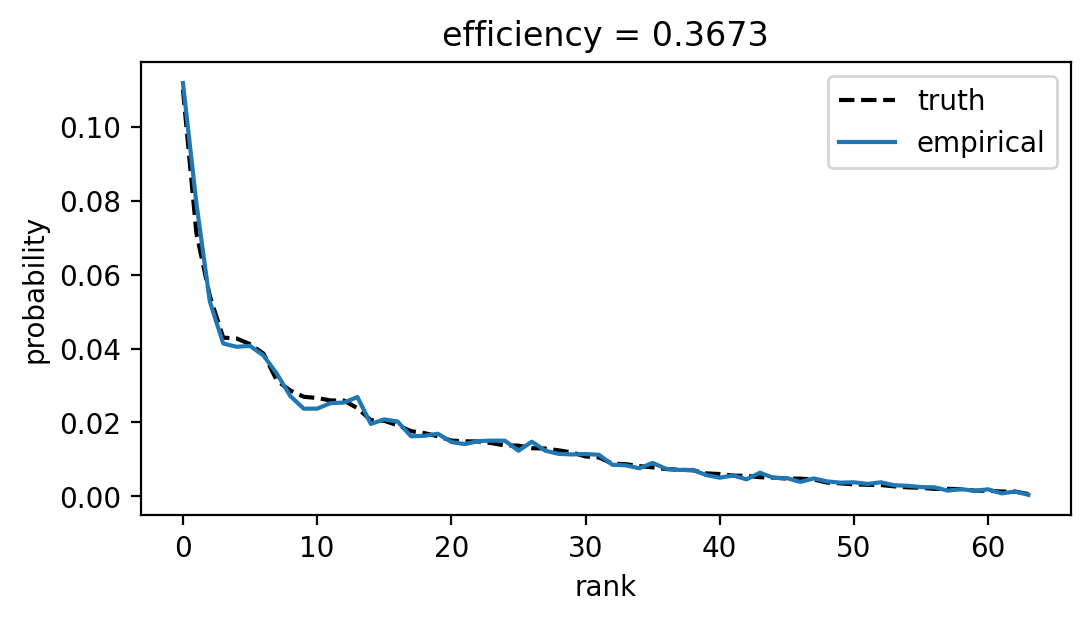

In [17]:
test_gof(adaptive_langevin, 6, 2)
test_gof(adaptive_langevin, 4, 3)
test_gof(adaptive_langevin, 3, 4)

## Comparing balancing functions

In [18]:
def get_trace(p: int, k: int, n: int, g: callable, mcmc: callable, seed=20220708):
    pyro.set_rng_seed(seed)
    d = random_potts(p, k)
    xs = []
    distances = Counter()
    for i, (x, distance) in tqdm(enumerate(mcmc(d, g)), total=n):
        xs.append(x)
        distances[distance] += 1
        if i >= n:
            break
    mean = sum(k * v for k, v in distances.items()) / sum(distances.values())
    print(f"mean distance = {mean:0.3f}")
    return torch.stack(xs)

Note that in log space where $x=\log(t)$, Barker's function becomes PyTorch's `logsigmoid` function:
$$
\log\circ(t\mapsto\frac t{1+t})\circ\exp = x\mapsto\log(\operatorname{sigmoid}(x))
$$

Similarly in log space, the sqrt function becomes
$$
  \log]\circ(t\mapsto\sqrt t)\circ\exp = x\mapsto x/2
$$

In [19]:
def eff(a: torch.Tensor) -> float:
    """Computes sample efficiency from autocorrelation."""
    # https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html
    cutoff = 1 + 10 * a[:len(a) // 2].abs().gt(0.5).long().sum().item()
    a = a[1:cutoff]  # lag 1 up to cutoff
    return 1 / (1 + 2 * a.sum().item())

def plot_autocorrelation(p, k, s=20000):
    x_adaptive = get_trace(p, k, s, g=lambda logt: logt / 2, mcmc=adaptive_langevin)
    a_adaptive = autocorrelation(x_adaptive, dim=0).mean([1,2])
    
    x_langevin = get_trace(p, k, s, g=lambda logt: logt / 2, mcmc=discrete_langevin)
    a_langevin = autocorrelation(x_langevin, dim=0).mean([1,2])
    
    x_barker = get_trace(p, k, s, g=torch.nn.functional.logsigmoid, mcmc=gibbs_with_gradients)
    a_barker = autocorrelation(x_barker, dim=0).mean([1,2])

    x_sqrt = get_trace(p, k, s, g=lambda logt: logt / 2, mcmc=gibbs_with_gradients)
    a_sqrt = autocorrelation(x_sqrt, dim=0).mean([1,2])

    plt.title(f"{p}-length sequences of {k}-sized alphabet")
    x = np.arange(1, 10001)
    plt.plot(x, a_barker[:10000], label=f"Barker (eff = {eff(a_barker):0.3g})")
    plt.plot(x, a_sqrt[:10000], label=f"sqrt (eff = {eff(a_sqrt):0.3g})")
    plt.plot(x, a_langevin[:10000], label=f"Langevin (eff = {eff(a_langevin):0.3g})")
    plt.plot(x, a_adaptive[:10000], label=f"adaptive (eff = {eff(a_adaptive):0.3g})")
    plt.ylabel("autocorrelation")
    plt.xlabel("1 + lag")
    plt.xlim(1, None)
    plt.xscale("log")
    plt.legend(loc="best")

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.560


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.170


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.476


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.483


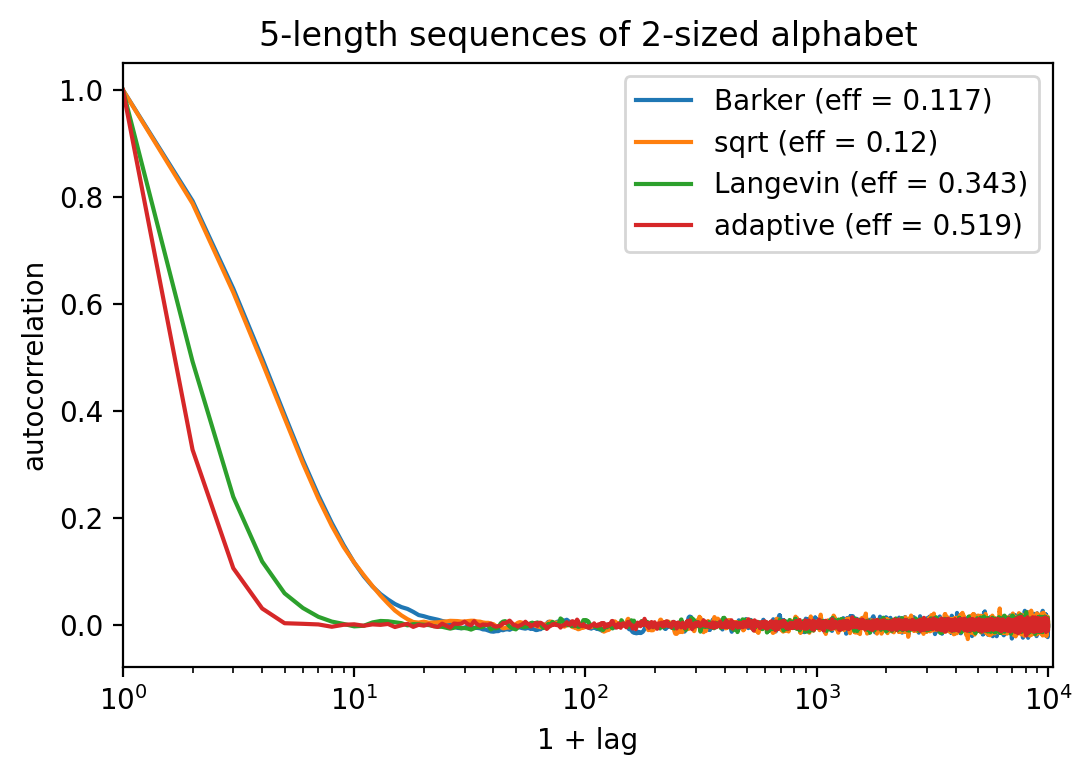

In [20]:
plot_autocorrelation(5, 2)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 2.426


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 3.121


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.687


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.700


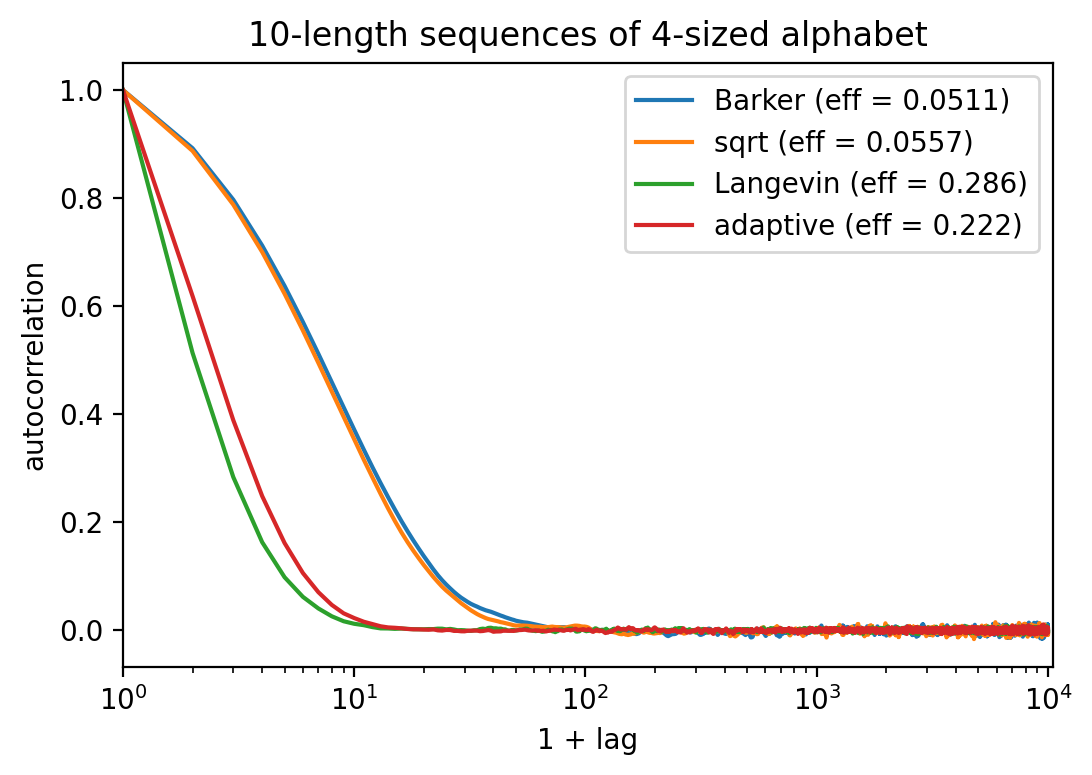

In [21]:
plot_autocorrelation(10, 4)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 3.696


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 3.678


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.820


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.834


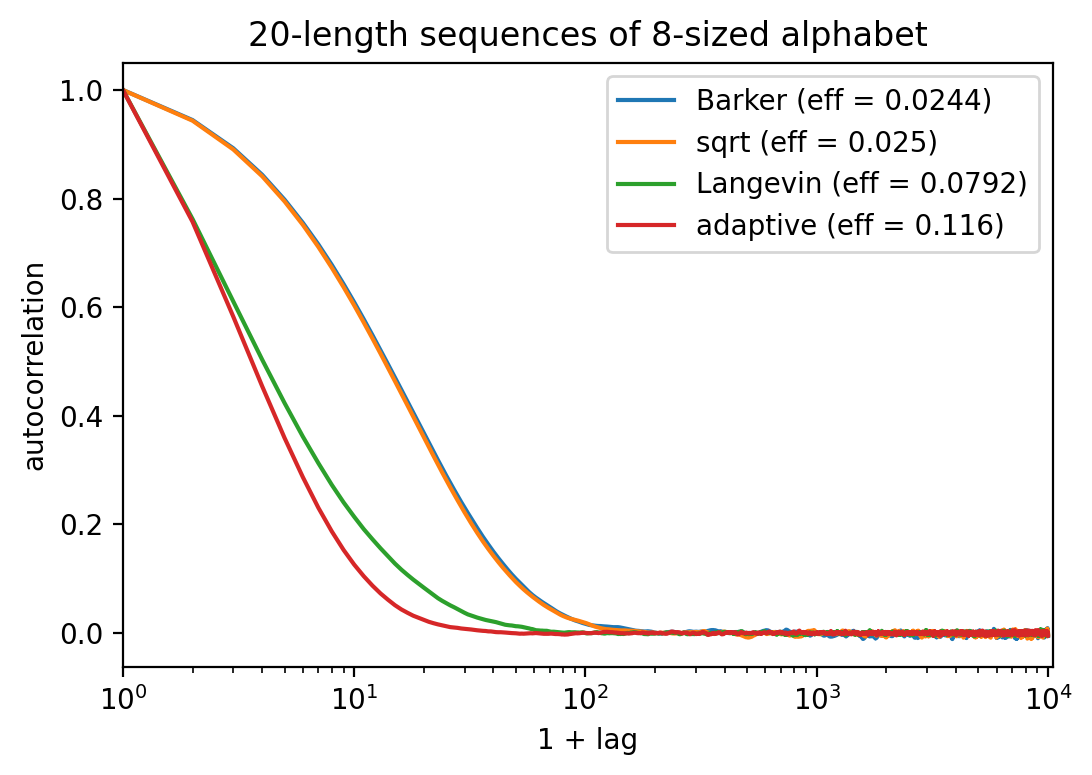

In [22]:
plot_autocorrelation(20, 8)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 4.450


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.084


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.903


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.913


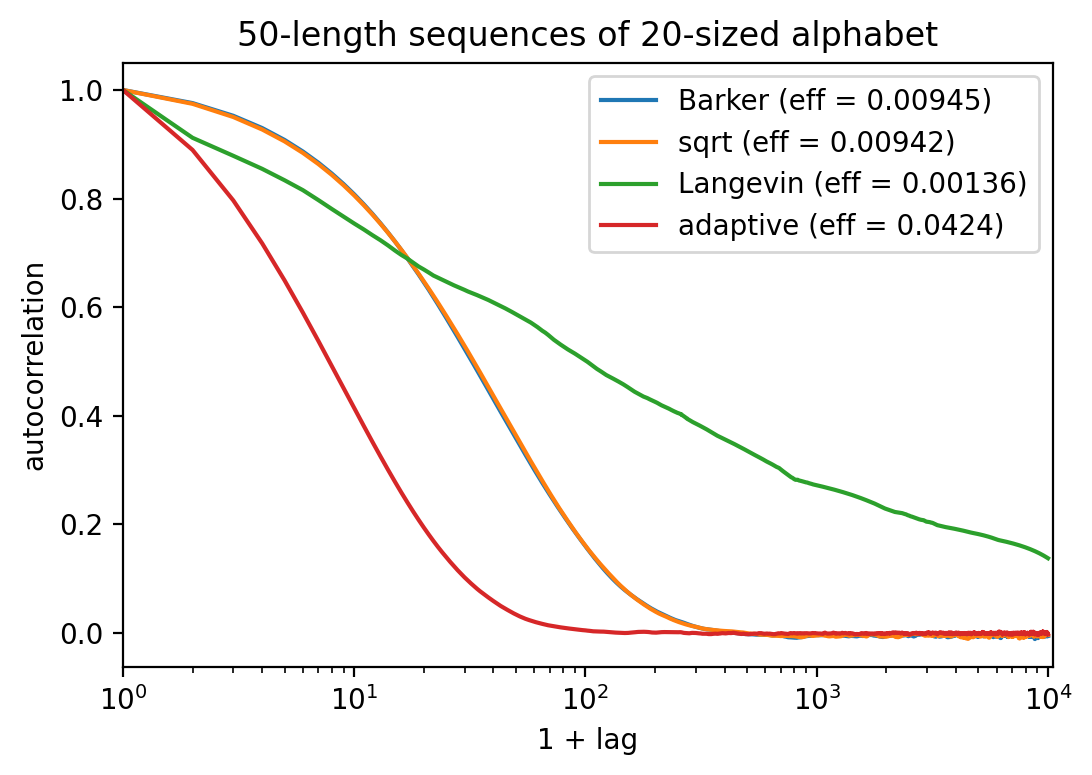

In [23]:
plot_autocorrelation(50, 20)

## Systematic comparison across temperatures

In [24]:
def get_eff(p: int, k: int, mcmc: callable, temperature: float, n=10000):
    d = random_potts(p, k, temperature=temperature)
    xs = []
    for i, (x, _) in enumerate(mcmc(d, g=lambda logt: logt / 2)):
        xs.append(x)
        if i >= n:
            break
    x = torch.stack(xs)
    a = autocorrelation(x, dim=0).mean([1,2])
    return eff(a)

In [25]:
def get_effs(ps, ks, mcmcs, temperatures):
    result = {}
    configs = list(itertools.product(ps, ks, mcmcs, enumerate(temperatures)))
    for p, k, mcmc, (seed, temperature) in tqdm(configs):
        pyro.set_rng_seed(seed)
        result[p, k, mcmc, temperature] = get_eff(p, k, mcmc, temperature)
    return result

In [26]:
%%time
ps = [32]
ks = [20]
mcmcs = [gibbs_with_gradients, discrete_langevin, adaptive_langevin]
ts = torch.logspace(-1, 1, 20).tolist()
effs = get_effs(ps, ks, mcmcs, ts)

  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 3min 22s, sys: 3.04 s, total: 3min 25s
Wall time: 3min 18s


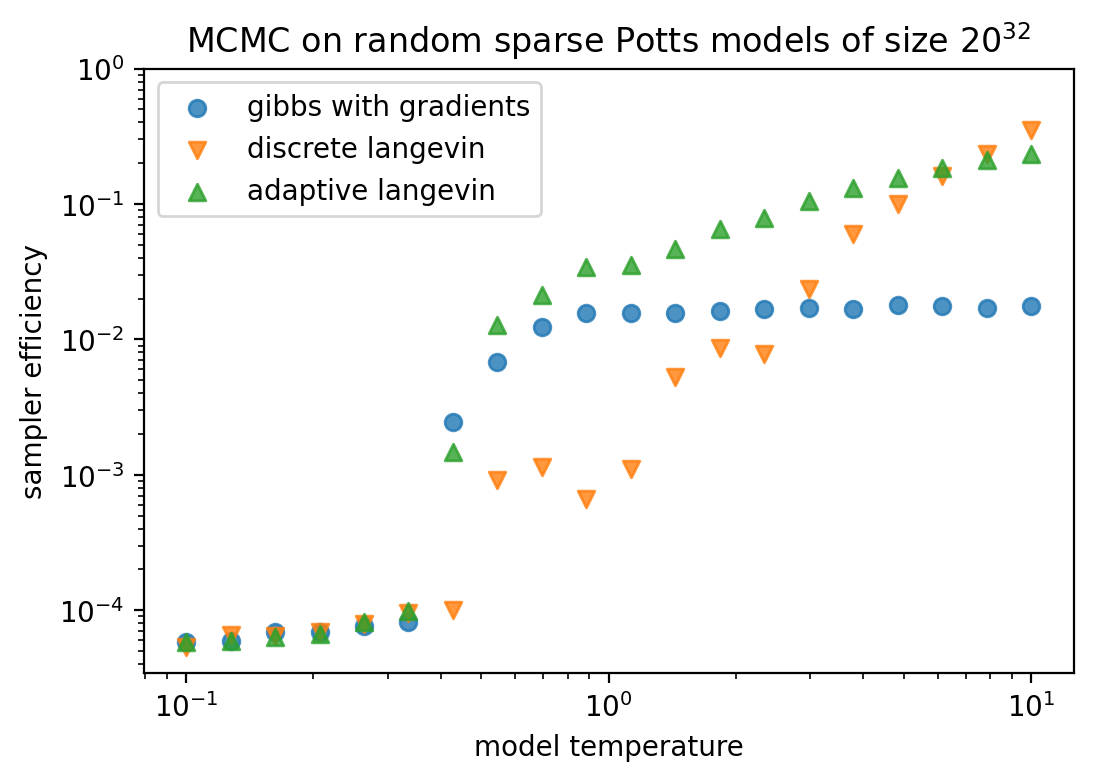

In [27]:
plt.figure(figsize=(6, 4))
markers = {
    gibbs_with_gradients: "o",
    discrete_langevin: "v",
    adaptive_langevin: "^",
}
for p, k, mcmc in itertools.product(ps, ks, mcmcs):
    plt.scatter(ts, [effs[p, k, mcmc, t] for t in ts], alpha=0.8,
                marker=markers[mcmc], label=mcmc.__name__.replace("_", " "))
plt.xscale("log")
plt.yscale("log")
plt.ylim(None, 1)
plt.xlabel("model temperature")
plt.ylabel("sampler efficiency")
plt.legend(loc="best")
plt.title(f"MCMC on random sparse Potts models of size ${ks[0]}^{{{ps[0]}}}$");